In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Avoid OOM Error
gpu = tf.config.experimental.list_physical_devices('GPU')[0]
tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
train_ds, val_ds, test_ds = tfds.load("cifar10", split=['train[:80%]', 'test[:10%]', 'test[:10%]'], as_supervised=True)

In [4]:
size = (32, 32)
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

In [5]:
CLASSES = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [6]:
rescale_resize = layers.Rescaling(1./255)

In [8]:
def prepare(ds: tf.data.Dataset):
    ds = ds.map(lambda x, y: (rescale_resize(x), y), num_parallel_calls=AUTOTUNE)    
    ds = ds.batch(batch_size).shuffle(1024).prefetch(AUTOTUNE).cache()
    return ds

In [9]:
train_ds = prepare(train_ds)
test_ds = prepare(test_ds)
val_ds = prepare(val_ds)

In [10]:
def show_batch(images, labels, pred_labels=None, num=25):
    font_dict = {'color': 'black'}

    fig = plt.figure(figsize=(20, 10))
    for i in range(num):
        ax = plt.subplot(5, 5, i+1)
        plt.imshow(images[i])
        if (pred_labels is not None):
            if (labels[i] == np.argmax(pred_labels[i])):
                font_dict['color'] = 'green'
            else:
                font_dict['color'] = 'red'
        
        plt.title(CLASSES[labels[i]], fontdict=font_dict)

        plt.axis("off")

In [11]:
train_iter = train_ds.as_numpy_iterator()

In [12]:
images, labels = train_iter.next()

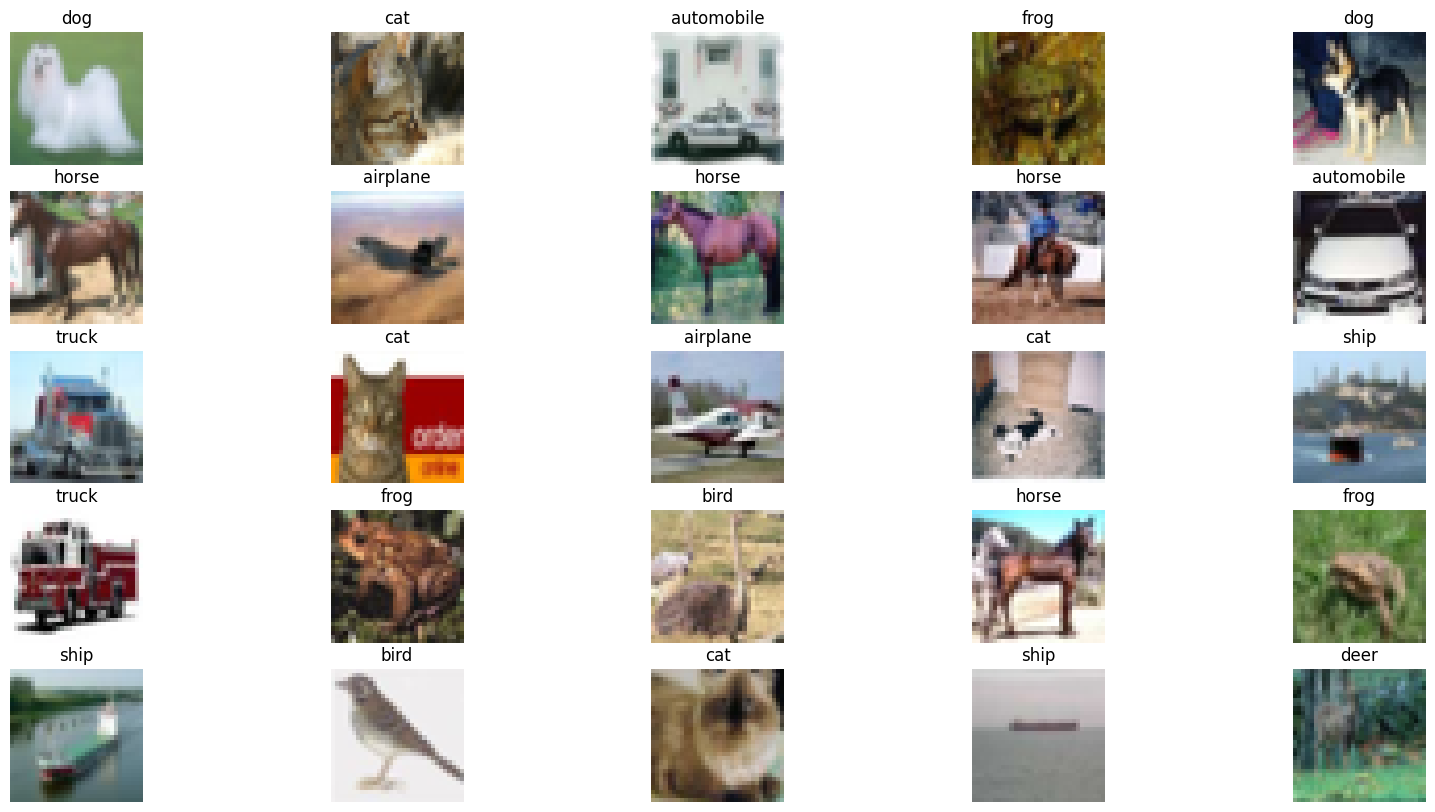

In [13]:
show_batch(images, labels)

## DL Model

### Data Augmentation

In [22]:
data_augment = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomTranslation(0.3, 0.3)
])

In [14]:
def conv_block(filters, dropout):
    block = tf.keras.Sequential([
        layers.Conv2D(filters, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(filters, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(dropout)
    ])
    return block

In [15]:
model = tf.keras.Sequential([
    layers.Input((*size, 3)),
    data_augment,
    
    conv_block(32, 0),
    conv_block(64, 0),
    conv_block(128, 0),

    layers.Flatten(),
    layers.Dense(512, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(10, activation="softmax")
])

In [16]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 32, 32, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 16, 16, 32)        10272     
                                                                 
 sequential_2 (Sequential)   (None, 8, 8, 64)          55680     
                                                                 
 sequential_3 (Sequential)   (None, 4, 4, 128)         221952    
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 batch_normalization_3 (Batc  (None, 512)             

In [17]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint("model/cifar10.h5", save_best_only=True)
]

In [18]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [19]:
history = model.fit(train_ds, epochs=200, validation_data=val_ds, callbacks=callbacks)

Epoch 1/200
1250/1250 [==============================] - 14s 7ms/step - loss: 2.0444 - accuracy: 0.2896 - val_loss: 2.7524 - val_accuracy: 0.2590
Epoch 2/200
1250/1250 [==============================] - 8s 6ms/step - loss: 1.7105 - accuracy: 0.3784 - val_loss: 3.1144 - val_accuracy: 0.2910
Epoch 3/200
1250/1250 [==============================] - 8s 6ms/step - loss: 1.5547 - accuracy: 0.4384 - val_loss: 1.4301 - val_accuracy: 0.4930
Epoch 4/200
1250/1250 [==============================] - 8s 6ms/step - loss: 1.4588 - accuracy: 0.4777 - val_loss: 1.8619 - val_accuracy: 0.4230
Epoch 5/200
1250/1250 [==============================] - 8s 6ms/step - loss: 1.3870 - accuracy: 0.5083 - val_loss: 1.2575 - val_accuracy: 0.5400
Epoch 6/200
1250/1250 [==============================] - 8s 6ms/step - loss: 1.3362 - accuracy: 0.5272 - val_loss: 1.2867 - val_accuracy: 0.5660
Epoch 7/200
1250/1250 [==============================] - 8s 6ms/step - loss: 1.2664 - accuracy: 0.5541 - val_loss: 1.3313 - val_a

In [20]:
model.evaluate(test_ds)

32/32 [==============================] - 0s 2ms/step - loss: 0.6005 - accuracy: 0.7870


[0.6004900336265564, 0.7870000004768372]

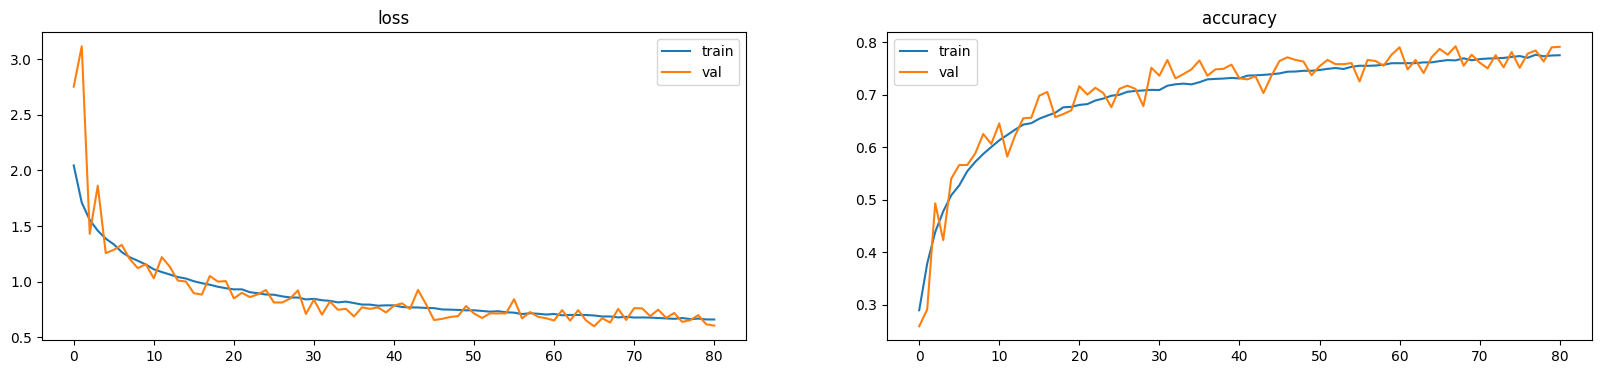

In [21]:
metrics = ['loss', 'accuracy']
fig, ax = plt.subplots(ncols=len(metrics), figsize=(20, 4))

for i, metric in enumerate(metrics):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history['val_'+metric])
    ax[i].legend(['train', 'val'])
    ax[i].set_title(metric)